In [1]:
import math

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# OUR LIBRARIES / FUNCTIONS
from ImageLoader import load_image, plot_loaded_images
from StarDetector import get_hough_circles, plot_detected_stars, get_stars_data
from StarMatching import calculate_transformation

# GLOBAL VARIABLES
# im1_path = r'Boaz stars 1.png'
# im2_path = r'Boaz stars 2.png'
im1_path = r'Stars/IMG_3046.HEIC'
im2_path = r'Stars/IMG_3047.HEIC'
# im1_path = r'Stars/IMG_3060.HEIC'
# im2_path = r'Stars/IMG_3061.HEIC'
# im1_path = "Ex1_test_101/fr1.jpg"
# im2_path = "Ex1_test_101/fr2.jpg"

MY_KEYPOINTS = False

In [2]:
im1 = load_image(im1_path)
im2 = load_image(im2_path)

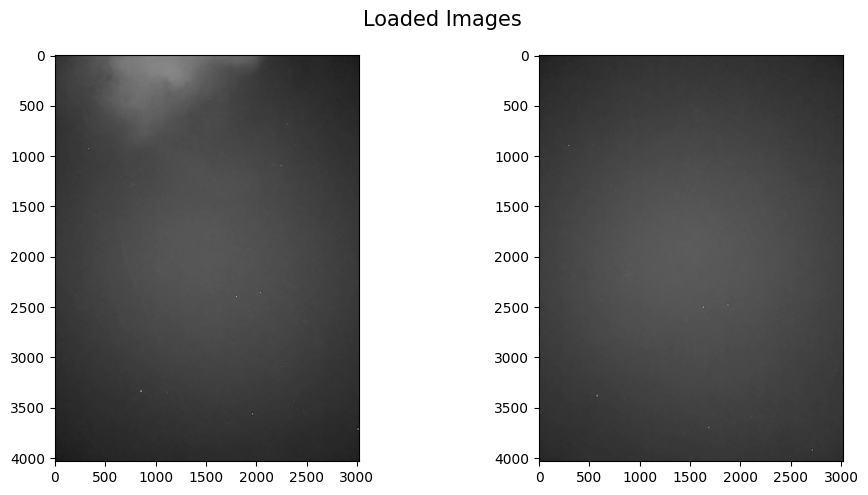

In [3]:
plot_loaded_images(im1, im2)
plt.show()

In [4]:
im1_circles = get_hough_circles(im1)
im2_circles = get_hough_circles(im2)

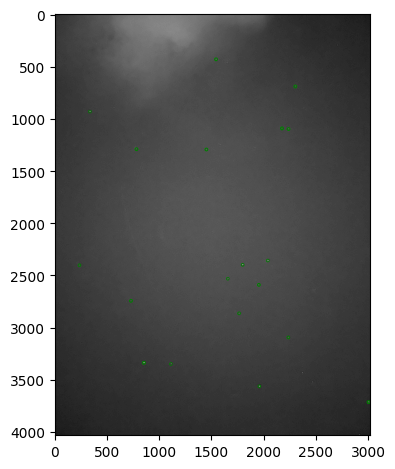

In [5]:
plot_detected_stars(im1, im1_circles)

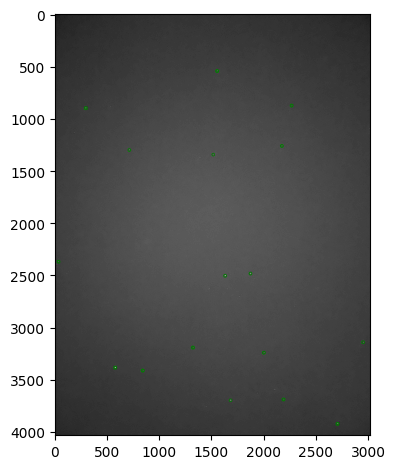

In [6]:
plot_detected_stars(im2, im2_circles)

In [7]:
im1_data = get_stars_data(im1, as_pandas=False)
im2_data = get_stars_data(im2, as_pandas=False)

In [8]:
im1_data

array([[3005, 3713,    5,  252],
       [1958, 3562,    3,  248],
       [2039, 2357,    3,  249],
       [1798, 2398,    3,  249],
       [ 852, 3337,    5,  254],
       [ 335,  930,    3,  250],
       [2303,  689,    4,  129],
       [2236, 3094,    3,  250],
       [1543,  429,    4,   97],
       [2238, 1097,    4,  205],
       [1764, 2863,    3,  243],
       [ 728, 2743,    4,  154],
       [1451, 1293,    4,   72],
       [2175, 1091,    5,   84],
       [ 781, 1290,    4,  222],
       [ 235, 2402,    3,  141],
       [1111, 3348,    3,  223],
       [1656, 2531,    3,   43],
       [1954, 2590,    4,   68]], dtype=uint32)

In [9]:
im2_data

array([[ 577, 3383,    5,  249],
       [1873, 2482,    4,  249],
       [2707, 3922,    5,  253],
       [1630, 2503,    4,  252],
       [1682, 3696,    3,  253],
       [2952, 3140,    3,  253],
       [ 296,  897,    5,  254],
       [2001, 3240,    4,  156],
       [ 713, 1298,    3,  128],
       [  34, 2368,    4,   39],
       [2267,  872,    4,  175],
       [2174, 1259,    4,   69],
       [2190, 3688,    4,   54],
       [1517, 1342,    3,    9],
       [ 841, 3411,    5,   54],
       [1322, 3191,    5,   61],
       [1554,  541,    5,  123]], dtype=uint32)

# Matching Algorithm

# Get keypoints

16
14


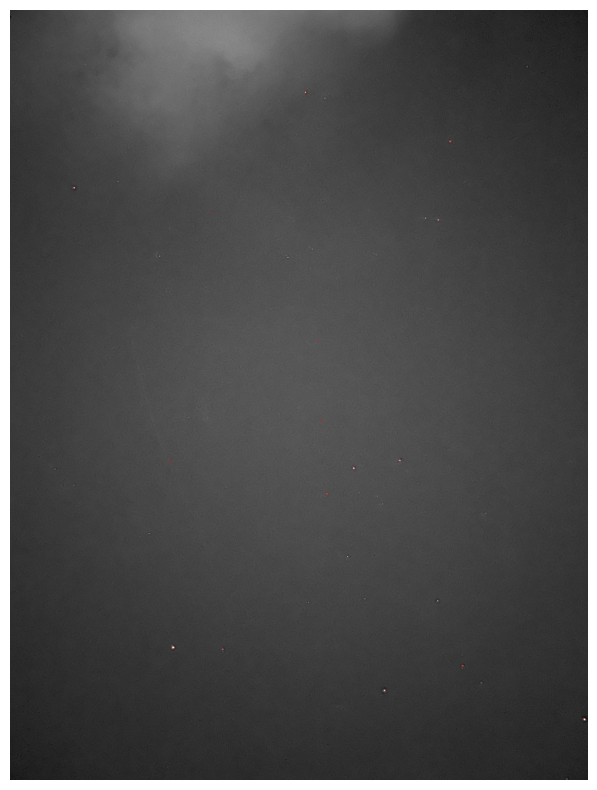

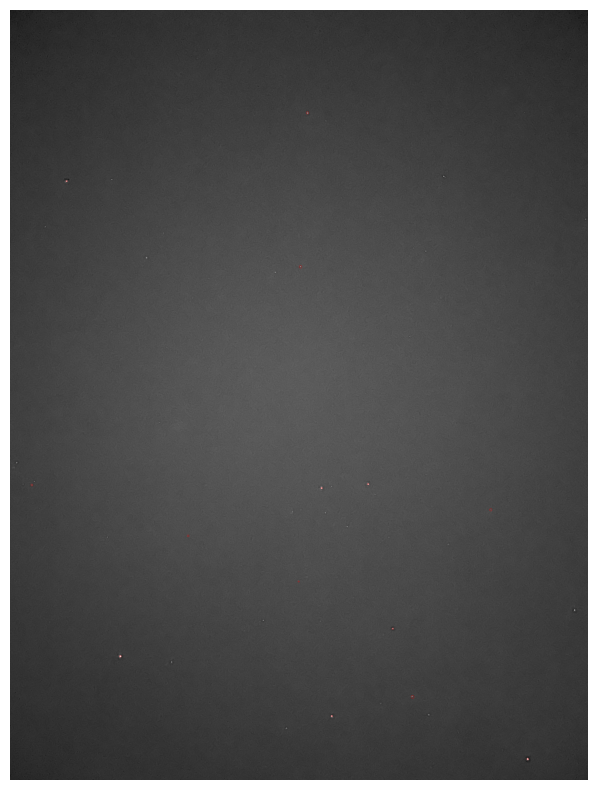

In [10]:
if MY_KEYPOINTS is True:
    keypoints1 = []
    for pt in im1_data:
        x, y, r, b = pt.astype(np.float32)
        diameter = 2 * r
        keypoints1.append(cv2.KeyPoint(x, y, diameter))

    keypoints2 = []
    for pt in im2_data:
        x, y, r, b = pt.astype(np.float32)
        diameter = 2 * r
        keypoints2.append(cv2.KeyPoint(x, y, diameter))

else:  # MY_KEYPOINTS is False
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()
    # # Change thresholds
    params.minThreshold = 60
    params.maxThreshold = 255

    # Filter by Area.
    params.filterByArea = True
    params.minArea = 30
    params.maxArea = 600

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.15

    params.filterByInertia = False
    params.filterByConvexity = False

    params.blobColor = 255
    params.minRepeatability = 2
    # Set up the detector with default parameters.

    detector = cv2.SimpleBlobDetector_create(params)

    keypoints1 = detector.detect(im1)
    keypoints2 = detector.detect(im2)

    print(len(keypoints1))
    print(len(keypoints2))

    im1_with_keypoints = cv2.drawKeypoints(im1, keypoints1, np.array([]),
                                           (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # Display the result using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(im1_with_keypoints)
    plt.axis('off')
    plt.show()

    im2_with_keypoints = cv2.drawKeypoints(im2, keypoints2, np.array([]),
                                           (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    # Display the result using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(im2_with_keypoints)
    plt.axis('off')
    plt.show()

# x, y = keypoints1[0].pt
# x = int(x)
# y = int(y)
# im1[y, x]

# Get keypoint descriptors

In [11]:
descriptor_extractor = cv2.ORB_create()
# Compute the descriptors for the keypoints (the returned keypoints remain the same!)
keypoints1, descriptors1 = descriptor_extractor.compute(im1, keypoints1)
keypoints2, descriptors2 = descriptor_extractor.compute(im2, keypoints2)

# Use the descriptors to match the keypoints of the 2 images

In [12]:
# Create a feature matching object.
matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

In [13]:
# Match the keypoints between the two images.
matches = matcher.match(descriptors1, descriptors2)
# sort the matches based on distance
matches = sorted(matches, key=lambda val: val.distance)
print(f"Found {len(matches)} matches")

Found 8 matches


In [14]:
result = cv2.drawMatches(im1, keypoints1,
                         im2, keypoints2,
                         matches, None,
                         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

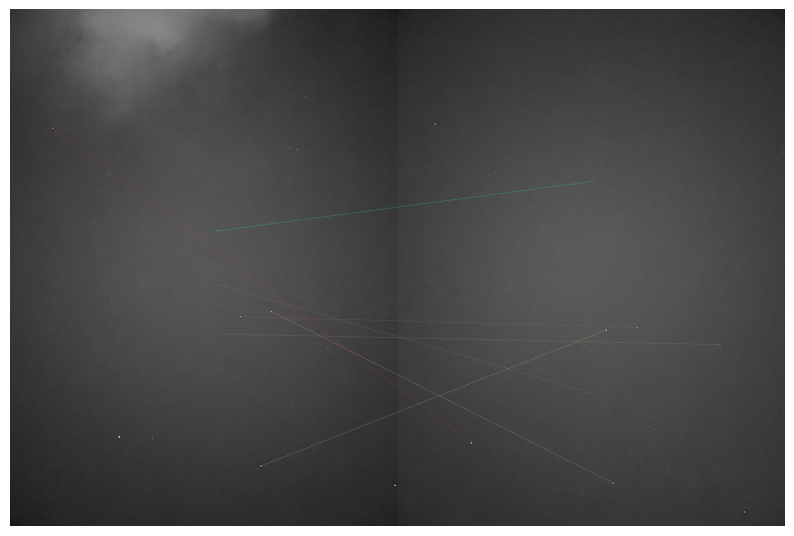

In [15]:
# Display the result using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(result)
ax.axis('off')
plt.show()

# Find transformation from Image1 to Image2

In [16]:
# # extract the (x, y) coordinates of the matched keypoints in both images
# points1 = np.zeros((len(matches), 2), dtype=np.float32)
# points2 = np.zeros((len(matches), 2), dtype=np.float32)
#
# for i, match in enumerate(matches):
#     points1[i, :] = keypoints1[match.queryIdx].pt
#     points2[i, :] = keypoints2[match.trainIdx].pt

# extract the (x, y) coordinates of the matched keypoints in both images
points1 = np.zeros((len(matches), 3), dtype=np.float32)
points2 = np.zeros((len(matches), 3), dtype=np.float32)

for i, match in enumerate(matches):
    kp1, kp2 = keypoints1[match.queryIdx], keypoints2[match.trainIdx]
    points1[i, :2], points1[i, 2] = kp1.pt, kp1.size / 2
    points2[i, :2], points2[i, 2] = kp2.pt, kp2.size / 2

In [17]:
# # estimate the homography matrix using RANSAC
# H, _ = cv2.findHomography(points1[:, :2], points2[:, :2], cv2.RANSAC)

In [18]:
# H

In [19]:
# # transform points from the first image to the second image
# src2dst = []
# for pt in points1[:, :2]:
#     x, y = pt
#     new_coords = H @ np.array([x, y, 1])
#     new_coords /= new_coords[-1]  # divide by last coordinate to normalize
#     if sum(new_coords[:-1] < 0) == 0:  # check that both x, y coordinates are positive!
#         src2dst.append(new_coords[:-1])
# src2dst = np.array(src2dst, dtype=np.float32)
# print(src2dst, points2[:, :2])

In [20]:
H = np.zeros(shape=(3, 3))
n_good_matches = 0
epochs = 200
dist_thresh = 5  # Set a distance threshold for matching points
for _ in range(epochs):
    counter = 0
    # estimate the homography matrix using RANSAC
    curr_H, _ = cv2.findHomography(points1[:, :2], points2[:, :2], cv2.RANSAC)
    # transform points from the first image to the second image
    for i, (p1, p2) in enumerate(zip(points1[:, :2], points2[:, :2])):
        x, y = p1
        new_coords = curr_H @ np.array([x, y, 1])
        new_coords /= new_coords[-1]  # divide by last coordinate to normalize
        new_coords = new_coords[:-1]
        if sum(new_coords < 0) == 0:  # check that both x, y coordinates are positive!
            curr_dist = np.linalg.norm(new_coords - p2)
            if curr_dist < dist_thresh:
                counter += 1
    if counter > n_good_matches:
        n_good_matches = counter
        H = curr_H.copy()
        assert np.sum(H != curr_H) == 0 # make sure curr_H was copied!

In [21]:
# transform points from the first image to the second image
matched_points = []
dist_thresh = 10  # Set a distance threshold for matching points
for i, (p1, p2) in enumerate(zip(points1[:, :2], points2[:, :2])):
    x, y = p1
    new_coords = H @ np.array([x, y, 1])
    new_coords /= new_coords[-1]  # divide by last coordinate to normalize
    new_coords = new_coords[:-1]
    if sum(new_coords < 0) == 0:  # check that both x, y coordinates are positive!
        curr_dist = np.linalg.norm(new_coords - p2)
        if curr_dist < dist_thresh:
            matched_points.append(i)

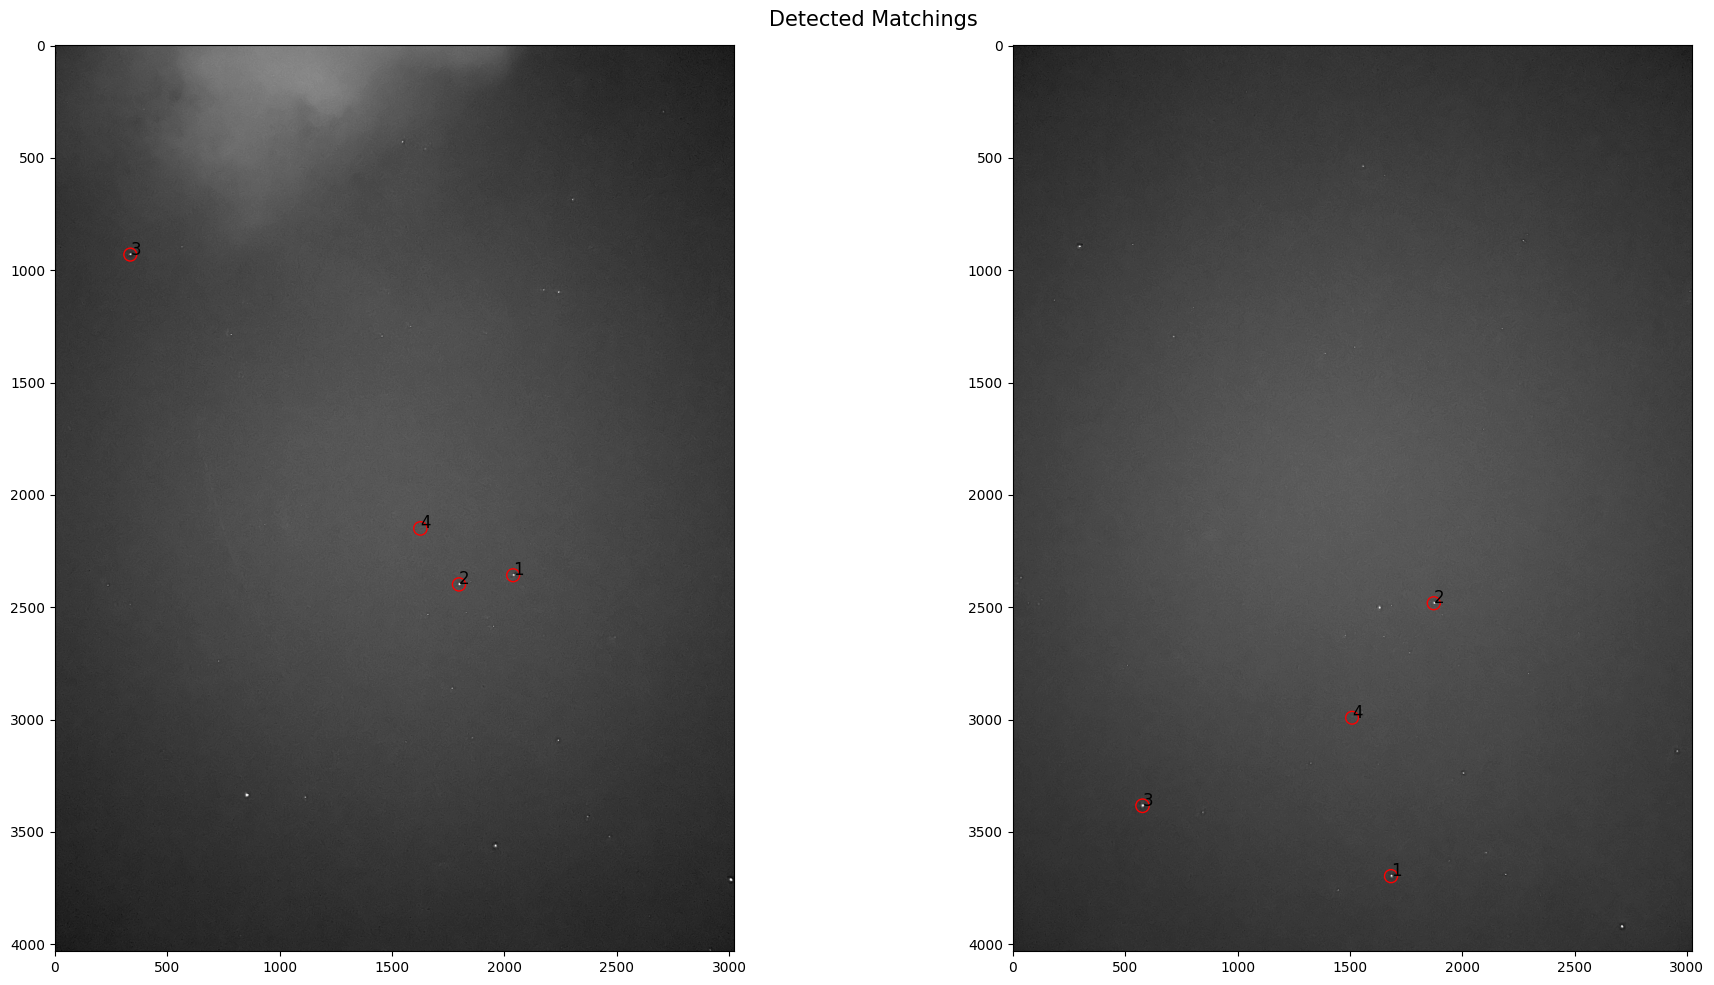

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
fig.suptitle("Detected Matchings", size=15)
ax[0].imshow(im1, cmap='gray')
ax[1].imshow(im2, cmap='gray')

for num, idx in enumerate(matched_points, 1):
    x1, y1, r1 = points1[idx]
    ax[0].text(x1, y1, f"{num}", fontsize=12, horizontalalignment='left', verticalalignment='baseline')
    ax[0].add_patch(plt.Circle((x1, y1), radius=r1 + 25, edgecolor='r', facecolor='none'))

    x2, y2, r2 = points2[idx]
    ax[1].text(x2, y2, f"{num}", fontsize=12, horizontalalignment='left', verticalalignment='baseline')
    ax[1].add_patch(plt.Circle((x2, y2), radius=r2 + 25, edgecolor='r', facecolor='none'))

plt.tight_layout()
plt.show()

In [23]:
# transformed_pts = []
# for kp1 in keypoints1:
#     p1 = kp1.pt
#     x, y = p1
#     new_coords = H @ np.array([x, y, 1])
#     new_coords /= new_coords[-1]  # divide by last coordinate to normalize
#     new_coords = new_coords[:-1]  # remove last index
#     if sum(new_coords < 0) == 0:  # check that both x, y coordinates are positive!
#         transformed_pts.append(new_coords)
# transformed_pts = np.array(transformed_pts, dtype=np.uint32)


In [27]:
# iterate the transformed points and look for a match in the original image
matched_points = []
dist_thresh = 10  # Set a distance threshold for matching points
for i, kp1 in enumerate(keypoints1):
    p1 = kp1.pt
    p1_transformed = calculate_transformation(H, p1)
    if p1_transformed is not None:
        for j, kp2 in enumerate(keypoints2):
            p2 = kp2.pt
            curr_dist = np.linalg.norm(p1_transformed - p2)
            if curr_dist < dist_thresh:
                matched_points.append((i, j, curr_dist))

matched_points = sorted(matched_points, key=lambda m: m[-1])
matched_points

[(7, 3, 9.165725883006586e-13),
 (10, 5, 2.8124570410120625e-12),
 (14, 2, 2.8124570410120625e-12),
 (9, 12, 3.6662903532026344e-12)]